In [1]:
# IMPORTS
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.fft import irfft, rfft, rfftfreq
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import norm
import pandas as pd
from scipy.signal import welch, get_window
%matplotlib widget 

from funcs_dsp import *
from funcs_df import load_df

In [2]:
# Load dataframe and grab waveforms
laptop = True
dfs_to_load = ["Curated Data"] # If this is empty, all are loaded
df = load_df(laptop=laptop, dfs_to_load=dfs_to_load)
# Crop to only wf
df = df[df['wf'].notna()]
# Crop to only species
df_human = df[df['species'].isin(["Human"])]
df_lizard = df[df['species'].isin(["Lizard", "Anolis"])]


Loading Curated Data
Combining into one Dataframe!


In [3]:
# Grab waveforms
h_idx = 0
l_idx = 0

wf_human = df_human.iloc[h_idx]['wf']
wf_lizard = df_lizard.iloc[l_idx]['wf']

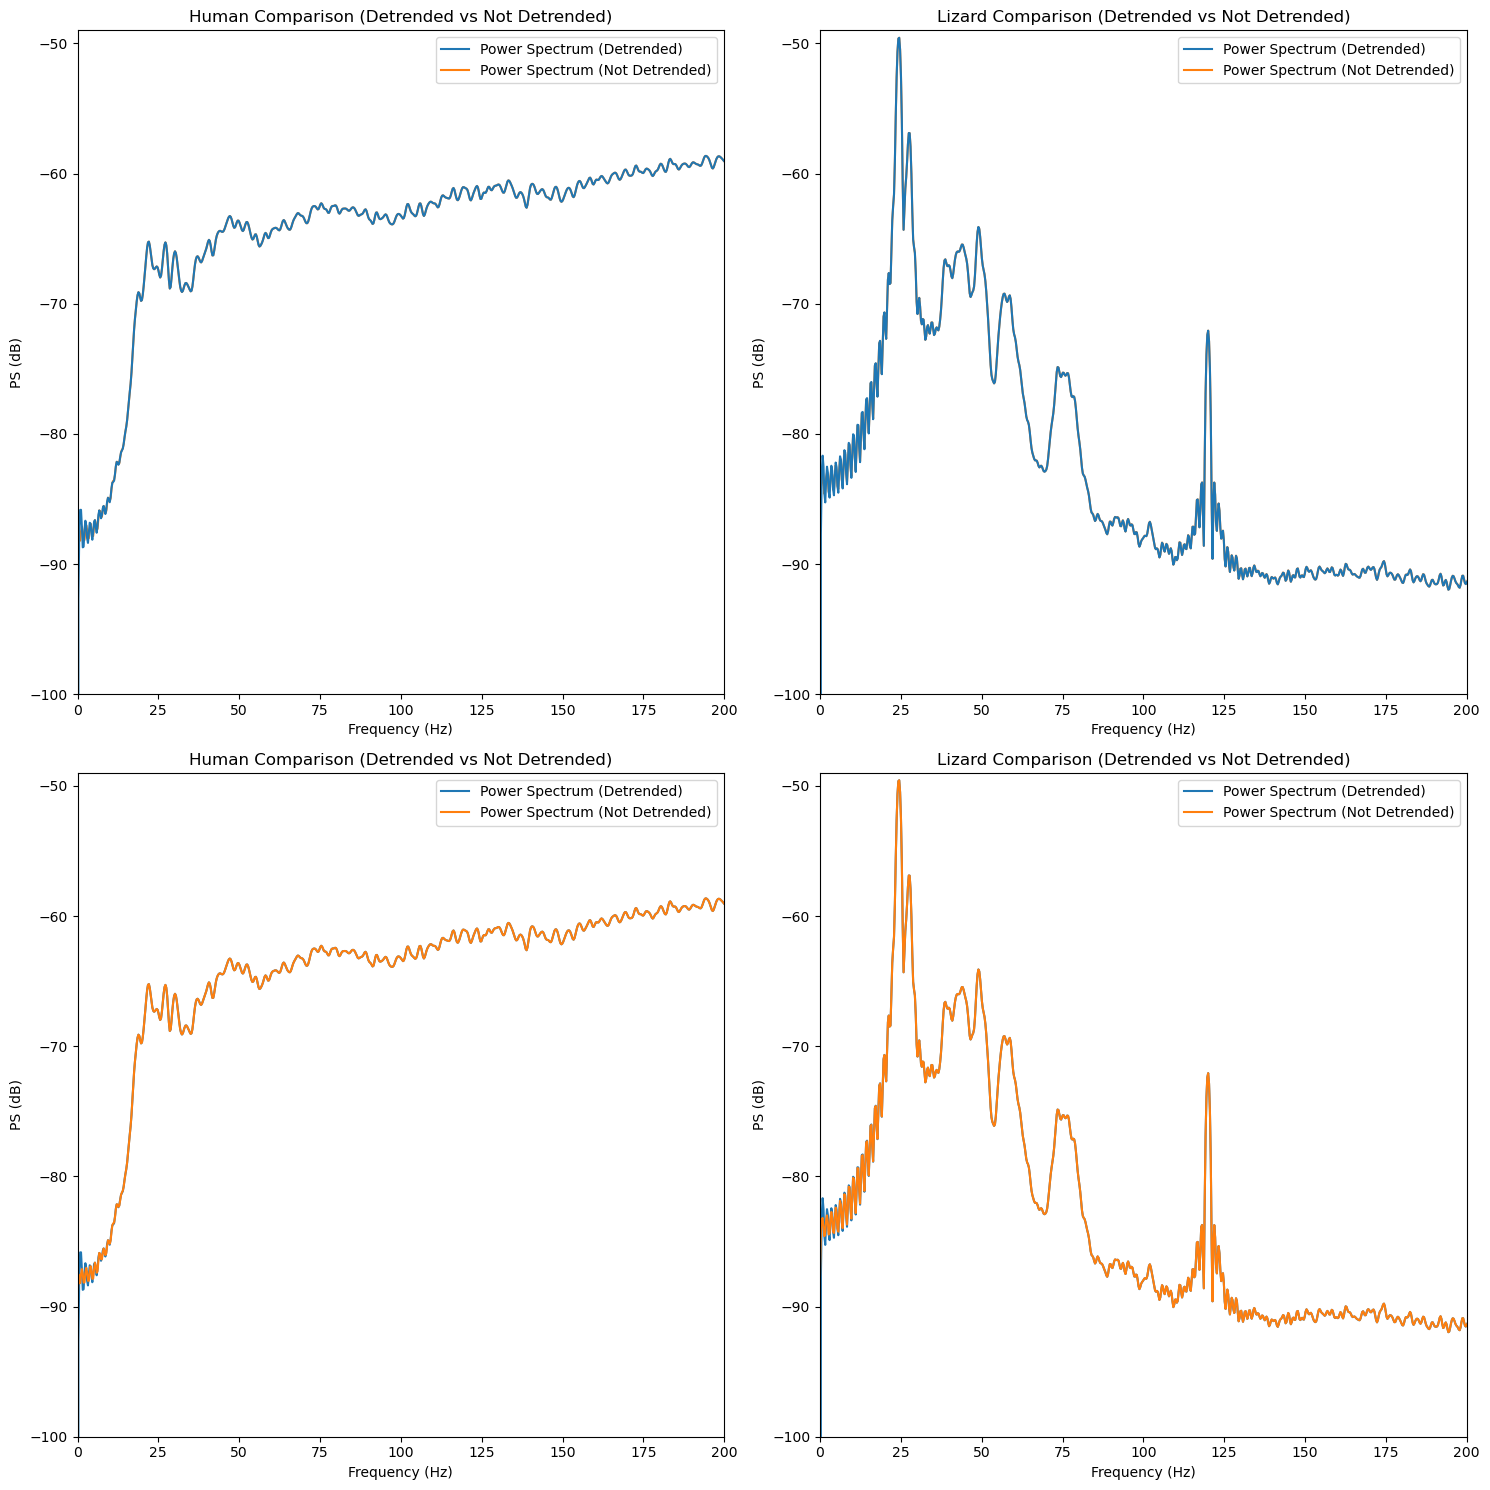

In [87]:
"Detrending"
win_type = 'boxcar'
nperseg = 32768
zero_pad = 5
nfft = nperseg*zero_pad

def plot_spectrum_detrending(wf, scaling, win_type, nperseg, nfft, detrend=False, db=True, zorder=1, fs=44100):
    f, spec = welch(wf, scaling=scaling, fs=fs, window=win_type, nperseg=nperseg, nfft=nfft, detrend=detrend)
    
    
    
    if scaling == 'spectrum':
        label = "Power Spectrum"
        ylabel = "PS"
    elif scaling == 'density':
        label = "Power Spectral Density"
        ylabel = "PSD"
    
    if detrend == "constant":
        label += " (Detrended)"
    elif detrend == False:
        label += " (Not Detrended)"
        
    if db:
        # Convert to dB
        spec = 10 * np.log10(spec)
        ylabel += " (dB)"
        
        
    fmax = 200
    ymin = -100
    ymax = -49

    plt.plot(f, spec, label=label, zorder=zorder)
    plt.xlim(0, fmax)
    plt.ylim(ymin, ymax)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel(ylabel)
    plt.legend()
    
    return f, spec

plt.figure(figsize=(15, 15))

for detrend_on_top in [True, False]:

    if detrend_on_top:
        z_detrend = 2
        z_not_detrend = 1
        p_number = 1
    else:
        z_detrend = 1
        z_not_detrend = 2
        p_number = 3

    plt.subplot(2, 2, p_number)
    
    plot_spectrum_detrending(wf_human, "spectrum", win_type, nperseg, nfft, detrend="constant", db=True, zorder=z_detrend)
    plt.title("Human Comparison (Detrended vs Not Detrended)")
    plot_spectrum_detrending(wf_human, "spectrum", win_type, nperseg, nfft, detrend=False, db=True, zorder=z_not_detrend)
    
    plt.subplot(2, 2, p_number + 1)

    plot_spectrum_detrending(wf_lizard, "spectrum", win_type, nperseg, nfft, detrend="constant", db=True, zorder=z_detrend)
    plt.title("Lizard Comparison (Detrended vs Not Detrended)")
    plot_spectrum_detrending(wf_lizard, "spectrum", win_type, nperseg, nfft, detrend=False, db=True, zorder=z_not_detrend)

plt.tight_layout()
plt.show()
    


In [118]:
# Plotting function for PS / PSD Comparisons
def plot_spectrum_ps_psd(wf, scaling, win_type, nperseg, nfft, detrend=False, db=True, zorder=1, fs=44100, ow_label=None):
    f, spec = welch(wf, scaling=scaling, fs=fs, window=win_type, nperseg=nperseg, nfft=nfft, detrend=detrend)
    
    if scaling == 'spectrum':
        label = "Power Spectrum"
        ylabel = "PS"
    elif scaling == 'density':
        label = "Power Spectral Density"
        ylabel = "PSD"
        
    if db:
        # Convert to dB
        spec = 10 * np.log10(spec)
        ylabel += " (dB)"
    else:
        ylabel += " (Linear)"
    
    if detrend == "constant":
        label += " (Detrended)"
    elif detrend == False:
        label += " (Not Detrended)"
        
    label+=f": nperseg={nperseg}"
    
    if ow_label is not None:
        label = ow_label

    plt.plot(f, spec, label=label, zorder=zorder)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel(ylabel)
    plt.legend()
    
    return f, spec

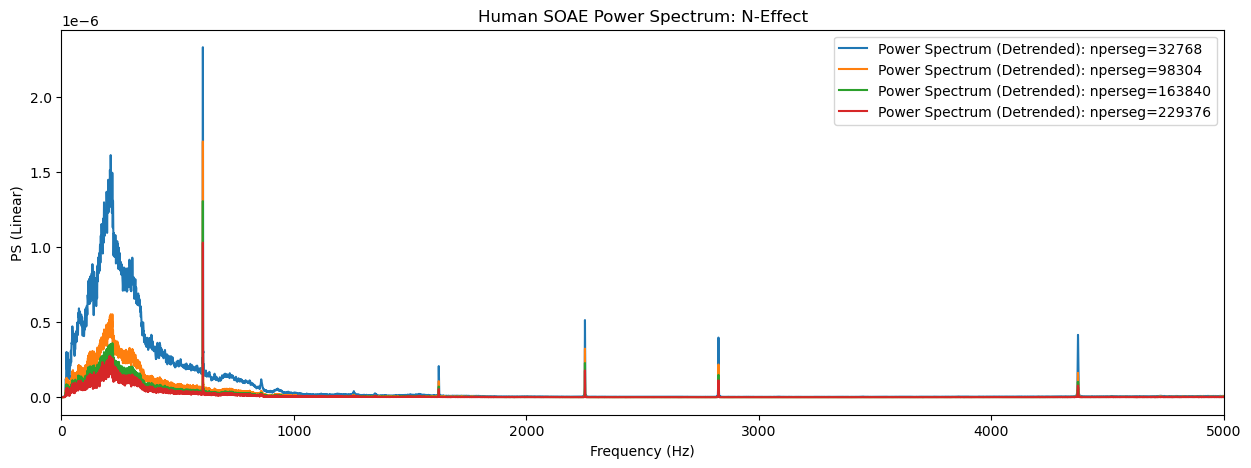

In [ ]:
"PS Human N-Effect"
detrend = "constant"
win_type = 'boxcar'
nperseg = 32768
nfft = nperseg*10

plt.figure(figsize=(15, 5))
plt.title("Human SOAE Power Spectrum: N-Effect")
for i in range(1, 8, 2):
    plot_spectrum_ps_psd(wf_human, "spectrum", win_type, nperseg*i, nfft, detrend=detrend, db=False)
    
ymin = -100
ymax = -50
fmax = 5000
plt.xlim(0, fmax)
# plt.ylim(ymin, ymax)

plt.show()
    


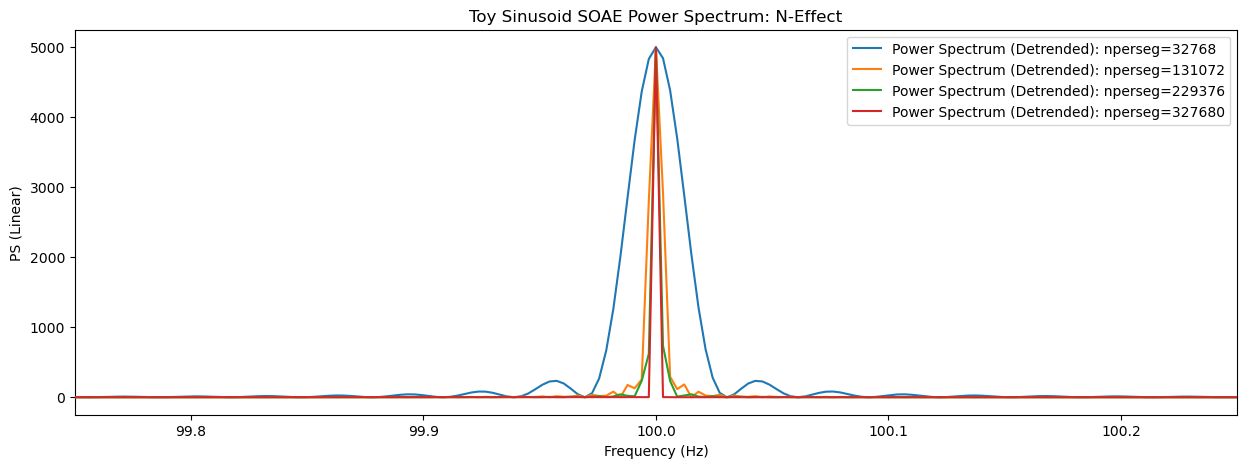

In [ ]:
"PS Toy N-Effect"
detrend = "constant"
win_type = 'boxcar'
nperseg = 32768
nfft = nperseg*10
# SIGNAL SAMPLING PARAMS
fs = 1000  # Sampling frequency in Hz
t_max = 1000 # Signal duration in seconds (bin width is 1/t_max)
N = fs * t_max  # Number of samples
t = np.linspace(0, t_max, N, endpoint=False)  # Time vector

# Signal parameters
freq = 100.00005  # Frequency of the sinusoid in Hz
decay_rate = 0 # Exponential decay rate
A = 100 # Amplitude of the decaying sinusoid
# Noise parameters
noise_power_density = 0 # Power of the noise in Power/Hz
effective_bandwidth = fs/2 # Effective bandwidth in Hz; AKA the frequency range we use from Nyquist sampling theorem
total_noise_power = noise_power_density * effective_bandwidth # Total noise power in entire signal. 
# This is now the variance of the white noise. Since then in the time domain, the total noise power is 1/N * sum((signal - 0)^2)... aka the variance!
noise = np.random.normal(loc=0, scale=np.sqrt(total_noise_power), size=N)

wf_toy = A * np.exp(-decay_rate * t) * np.sin(2 * np.pi * freq * t) + noise

plt.figure(figsize=(15, 5))
plt.title("Toy Sinusoid SOAE Power Spectrum: N-Effect")
for i in range(1, 13, 3):
    plot_spectrum_ps_psd(wf_toy, "spectrum", win_type, nperseg*i, nfft, detrend=detrend, db=False, zorder=int(100*i), fs=fs)
    
ymin = -110
ymax = -80
fmin = freq - 0.25
fmax = freq + 0.25
plt.xlim(fmin, fmax)
# plt.ylim(ymin, ymax)

plt.show()

In [87]:
"PSD N-Effect Parameters"
detrend = "constant"
win_type = 'boxcar'
nperseg = 32768
nfft = nperseg*10
db = True

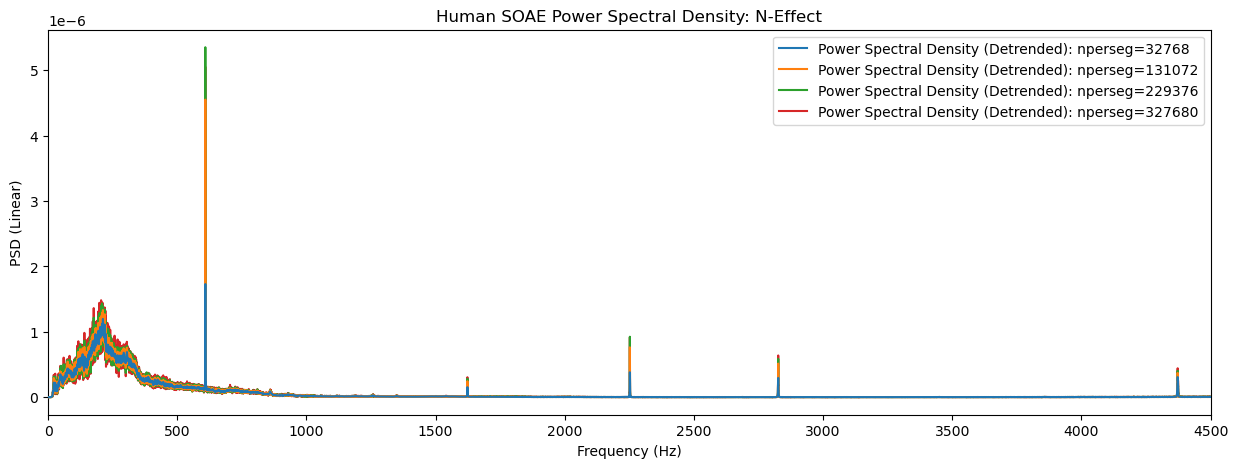

In [103]:
"PSD Human N-Effect"

plt.figure(figsize=(15, 5))
plt.title("Human SOAE Power Spectral Density: N-Effect")
for i in range(1, 13, 3):
    plot_spectrum_ps_psd(wf_human, "density", win_type, nperseg*i, nfft, detrend=detrend, db=False, zorder=int(100/i))
    
ymin = -100
ymax = -50
fmin = 0
fmax = 4500
plt.xlim(fmin, fmax)
# plt.ylim(ymin, ymax)

plt.show()
    
    


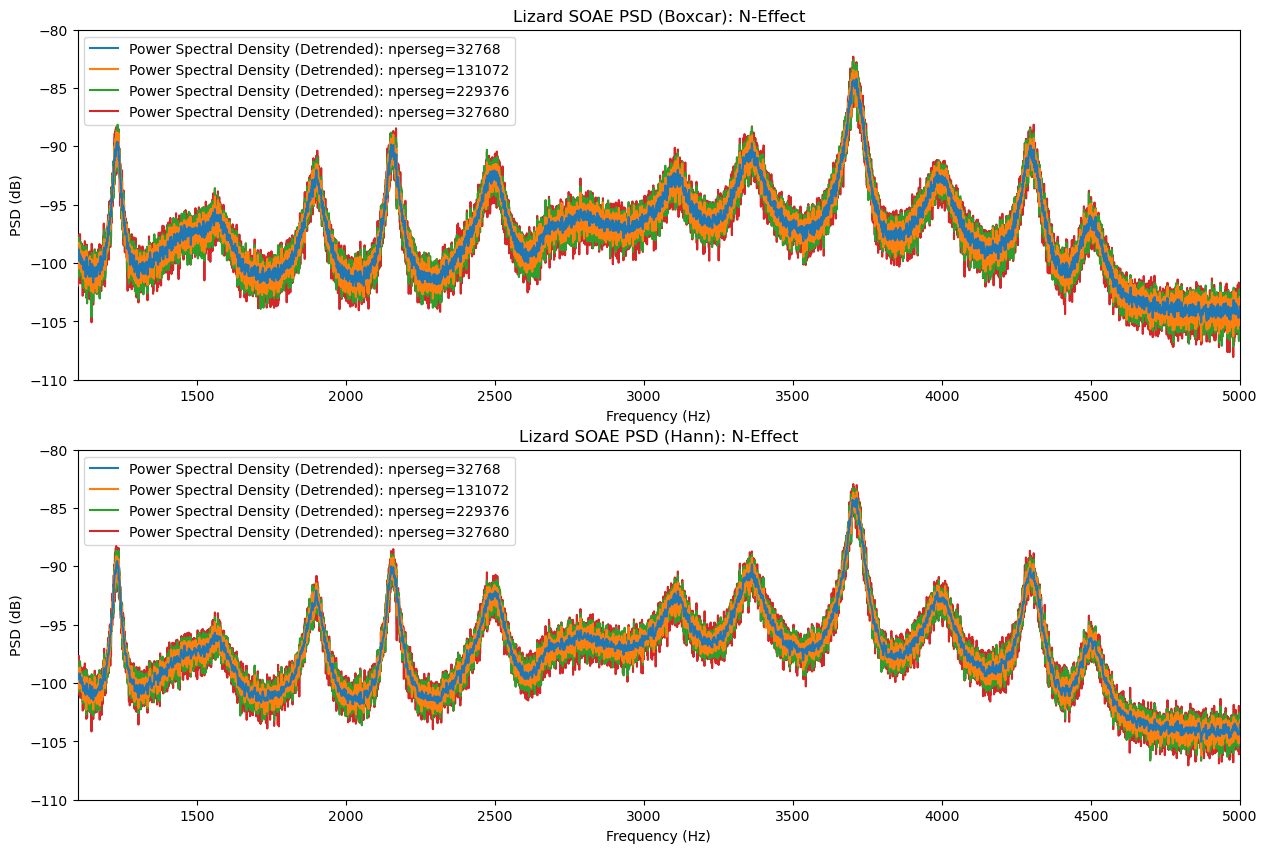

In [50]:
"PSD Lizard N-Effect"
detrend = "constant"
win_type = 'boxcar'
nperseg = 32768
nfft = nperseg*10
db = True
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.title("Lizard SOAE PSD: N-Effect")
for i in range(1, 13, 3):
    plot_spectrum_ps_psd(wf_lizard, "density", win_type, nperseg*i, nfft, detrend=detrend, db=db, zorder=int(100/i))
    
ymin = -110
ymax = -80
fmin = 1100
fmax = 5000
plt.xlim(fmin, fmax)
plt.ylim(ymin, ymax)

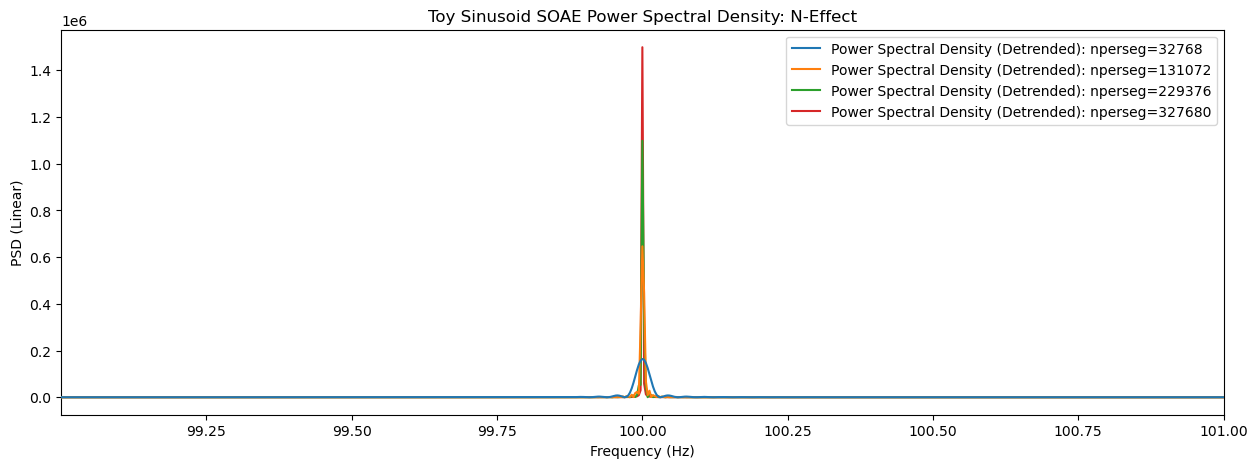

In [ ]:
"PSD Toy N-Effect"
# SIGNAL SAMPLING PARAMS
fs = 1000  # Sampling frequency in Hz
t_max = 1000 # Signal duration in seconds (bin width is 1/t_max)
N = fs * t_max  # Number of samples
t = np.linspace(0, t_max, N, endpoint=False)  # Time vector

# Signal parameters
freq = 100.0005  # Frequency of the sinusoid in Hz
decay_rate = 1 # Exponential decay rate
A = 100 # Amplitude of the decaying sinusoid
# Noise parameters
noise_power_density = 0 # Power of the noise in Power/Hz
effective_bandwidth = fs/2 # Effective bandwidth in Hz; AKA the frequency range we use from Nyquist sampling theorem
total_noise_power = noise_power_density * effective_bandwidth # Total noise power in entire signal. 
# This is now the variance of the white noise. Since then in the time domain, the total noise power is 1/N * sum((signal - 0)^2)... aka the variance!
noise = np.random.normal(loc=0, scale=np.sqrt(total_noise_power), size=N)

wf_toy = A * np.exp(-decay_rate * t) * np.sin(2 * np.pi * freq * t) + noise

plt.figure(figsize=(15, 5))
plt.title("Toy Sinusoid SOAE Power Spectral Density: N-Effect")
for i in range(1, 13, 3):
    plot_spectrum_ps_psd(wf_toy, "density", win_type, nperseg*i, nfft, detrend=detrend, db=False, zorder=int(100/i), fs=fs)
    
ymin = -110
ymax = -80
fmin = freq - 1
fmax = freq + 1
plt.xlim(fmin, fmax)
# plt.ylim(ymin, ymax)

plt.show()

In [15]:
# Plotting function for PS / PSD Comparisons
def plot_spectrum_window_compare(wf, scaling, win_type, nperseg, nfft, detrend=False, db=True, zorder=1, fs=44100):
    f, spec = welch(wf, scaling=scaling, fs=fs, window=win_type, nperseg=nperseg, nfft=nfft, detrend=detrend)
    
    if scaling == 'spectrum':
        label = "PS"
        ylabel = "PS"
    elif scaling == 'density':
        label = "PSD"
        ylabel = "PSD"
    
    win_type = win_type.capitalize()
    label+=f" with {win_type}"
    
    total_power = np.sum(spec) * fs / nfft
    print(f"Total average power ({win_type}) = {total_power}")
    
    if db:
        # Convert to dB
        spec = 10 * np.log10(spec)
        ylabel += " (dB)"
    else:
        ylabel += " (Linear)"
    
    if detrend == "constant":
        label += " (Detrended)"
    elif detrend == False:
        label += " (Not Detrended)"
        
    label+=f": nperseg={nperseg}"

    plt.plot(f, spec, label=label, zorder=zorder)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel(ylabel)
    plt.legend()
    
    return f, spec

In [29]:
def get_power_td(wf, nperseg):
    powers = []
    for i in range(int(len(wf) / nperseg)):
        powers.append(np.sum(wf[i*nperseg:(i+1)*nperseg]**2))
    return np.mean(powers) / nperseg
        
    

Total average power (Time) =  2.0565810920984395e-05
Total power (Boxcar) = 2.0568368935821638e-05
Total power (Hann) = 2.0588202801802763e-05


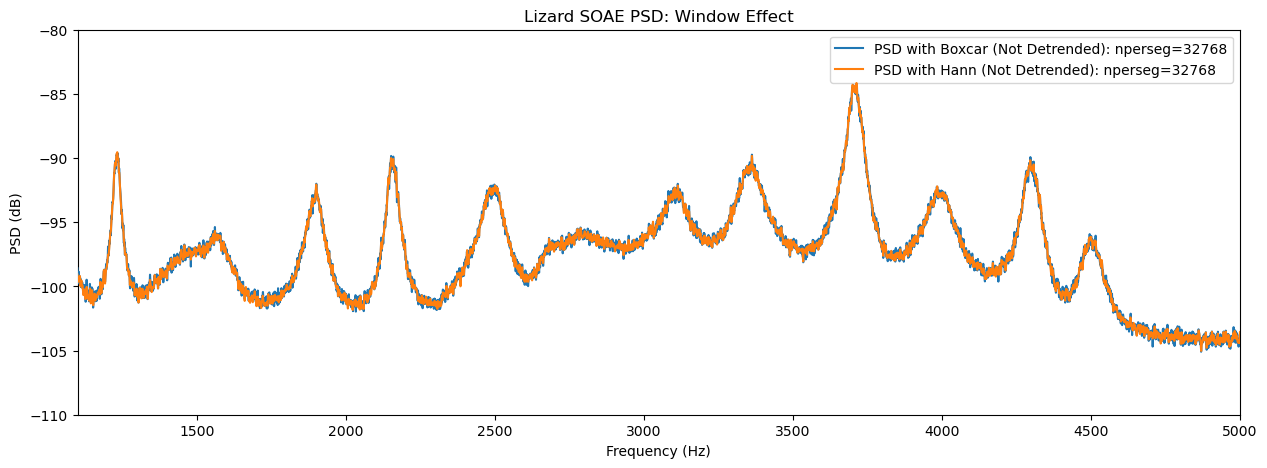

In [112]:
"Lizard PSD: Boxcar vs Hann"
print("Total average power (Time) = ", get_power_td(wf_lizard, nperseg))
detrend=False
plt.figure(figsize=(15, 5))
plt.title("Lizard SOAE PSD: Window Effect")
for (i, win_type) in enumerate(['boxcar', 'hann']):
    plot_spectrum_window_compare(wf_lizard, 'density', win_type, nperseg, nfft, detrend=detrend, db=db, zorder=int((i+1)*100))
    
ymin = -110
ymax = -80
fmin = 1100
fmax = 5000
plt.xlim(fmin, fmax)
plt.ylim(ymin, ymax)

plt.show()

Total average power (Time) =  0.000331118329333653
Total average power (Boxcar) = 0.00033175271110611403
Total average power (Hann) = 0.0003072796908254174
Total average power (Blackman) = 0.00028488704509988406


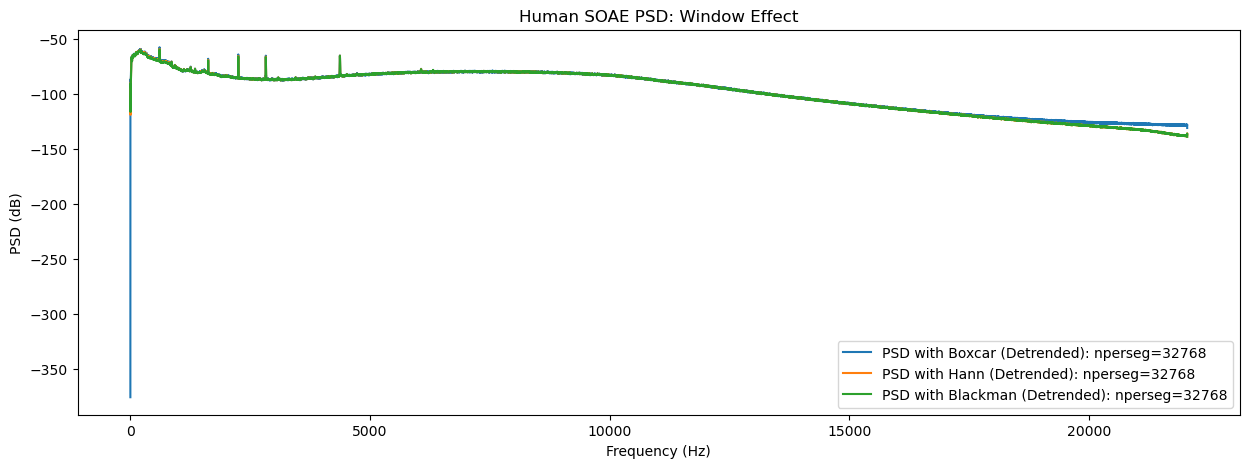

In [19]:
"Human PSD: Boxcar vs Hann"
detrend = "constant"
win_type = 'boxcar'
nperseg = 32768
nfft = nperseg*10
db = True
print("Total average power (Time) = ", get_power_td(wf_human, nperseg))
plt.figure(figsize=(15, 5))
plt.title("Human SOAE PSD: Window Effect")
nperseg = 32768
nfft = nperseg*10
db = True
detrend=False
for (i, win_type) in enumerate(['boxcar', 'hann', 'blackman']):
    plot_spectrum_window_compare(wf_human, 'density', win_type, nperseg, nfft, detrend='constant', db=db, zorder=int((i+1)*100))
    
ymin = -90
ymax = -50
fmin = 0
fmax = 5000
# plt.xlim(fmin, fmax)
# plt.ylim(ymin, ymax)

plt.show()

Total average power (Time) =  10017.180418209015
Total average power (Boxcar) = 10015.91662507828
Total average power (Hann) = 10010.323579746268


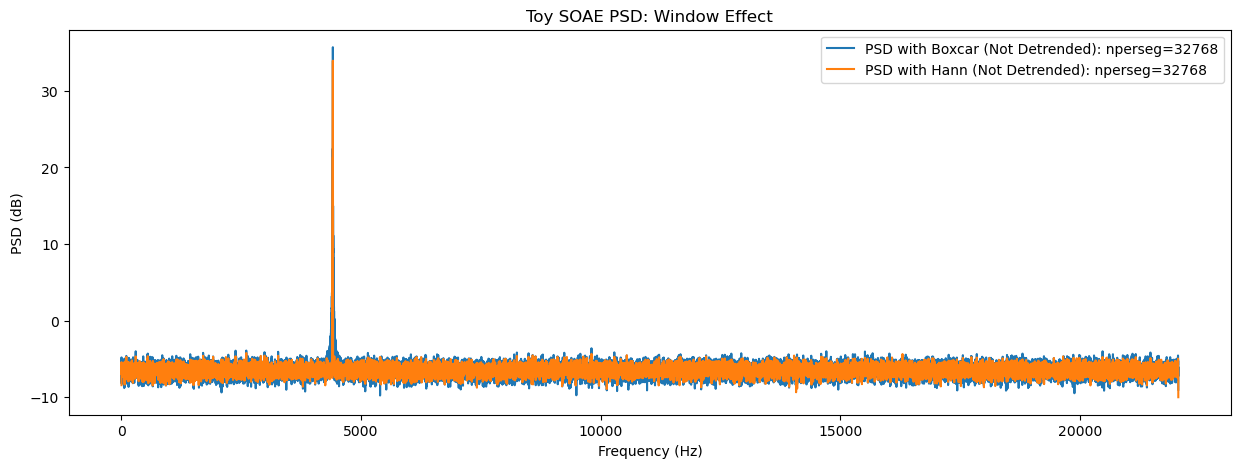

In [33]:
"Toy Sinusoid PSD: Boxcar vs Hann"

nperseg = 32768*4
nfft = nperseg*10
db = True
detrend=False

# SIGNAL SAMPLING PARAMS
fs = 1000  # Sampling frequency in Hz
t_max = 1000 # Signal duration in seconds (bin width is 1/t_max)
N = fs * t_max  # Number of samples
t = np.linspace(0, t_max, N, endpoint=False)  # Time vector

# Signal parameters
freq = 100.0005  # Frequency of the sinusoid in Hz
decay_rate = 0 # Exponential decay rate
A = 100 # Amplitude of the decaying sinusoid
# Noise parameters
noise_power_density = 10 # Power of the noise in Power/Hz
effective_bandwidth = fs/2 # Effective bandwidth in Hz; AKA the frequency range we use from Nyquist sampling theorem
total_noise_power = noise_power_density * effective_bandwidth # Total noise power in entire signal. 
# This is now the variance of the white noise. Since then in the time domain, the total noise power is 1/N * sum((signal - 0)^2)... aka the variance!
noise = np.random.normal(loc=0, scale=np.sqrt(total_noise_power), size=N)

wf_toy = A * np.exp(-decay_rate * t) * np.sin(2 * np.pi * freq * t) + noise

print("Total average power (Time) = ", get_power_td(wf_toy, nperseg))
plt.figure(figsize=(15, 5))
plt.title("Toy SOAE PSD: Window Effect")
nperseg = 32768
nfft = nperseg*10
db = True
detrend=False
for (i, win_type) in enumerate(['boxcar', 'hann']):
    plot_spectrum_window_compare(wf_toy, 'density', win_type, nperseg, nfft, detrend=detrend, db=db, zorder=int((i+1)*100))
    
ymin = -90
ymax = -50
fmin = 0
fmax = 5000
# plt.xlim(fmin, fmax)
# plt.ylim(ymin, ymax)

# plt.show()

Number of segments =  80
Total average power (Time) =  0.0003323642880042279
Total average power (Boxcar) = 0.0002236794954545516
Total average power (Hann) = 0.0003544462938810673
Total average power (Blackman) = 0.00042659775849385634


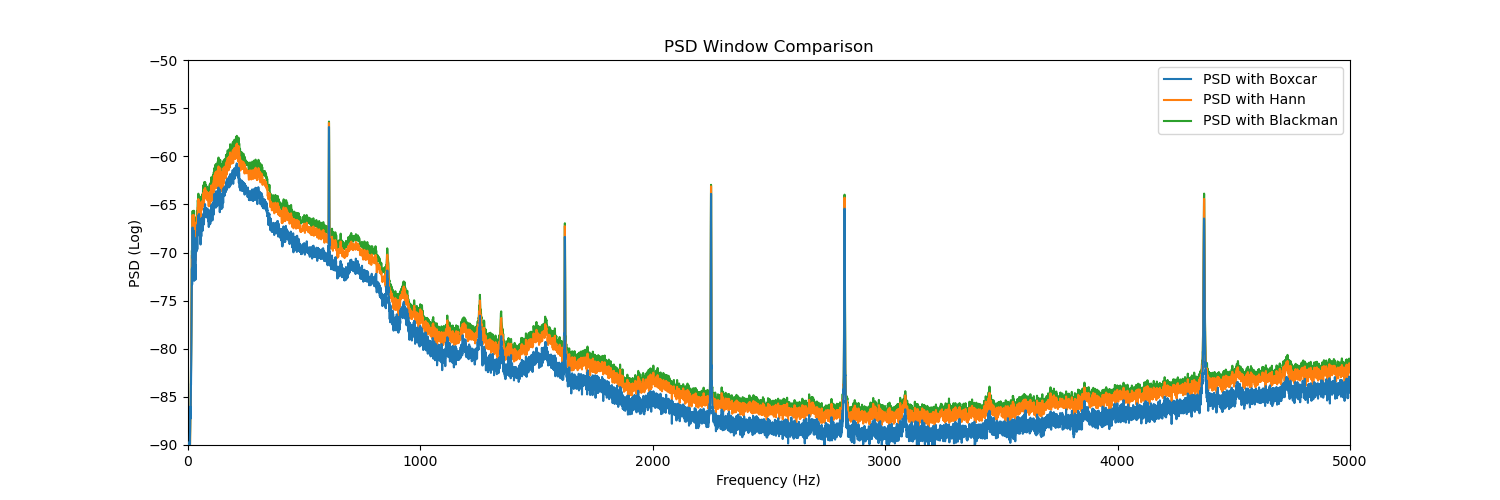

In [15]:
"PSD: Boxcar vs Hann vs Blackman (SE)"
from scipy.signal import welch
wf = wf_human

# Set Welch params
fs = 44100
nperseg = int(32768 * 2) # * 0.5 displays the scallops of one of the peaks!
nfft = nperseg*10
bin_width = fs/nfft
detrend = "constant"
scaling ='spectrum'

print("Number of segments = ", int(len(wf) / nperseg))

# Get average power in time domain (this method is overkill, but ensures analogy to the Welch calculations)
powers = []
for i in range(int(len(wf) / nperseg)):
    powers.append(np.sum(wf[i*nperseg:(i+1)*nperseg]**2))
time_avg_power = np.mean(powers) / nperseg
print("Total average power (Time) = ", time_avg_power)

# Initialize plot
plt.figure(figsize=(15, 5))
plt.title("PSD Window Comparison")

for (i, win_type) in enumerate(['boxcar', 'hann', 'blackman']):
    f, spec = welch(wf, scaling=scaling, fs=fs, window=win_type, nperseg=nperseg, nfft=nfft, detrend=detrend)
    
    win_type = win_type.capitalize()
    label = f"PSD with {win_type}"
    
    # Integrate over PSD
    total_power = np.sum(spec) * bin_width
    
    # Convert to log scale
    spec = 10 * np.log10(spec)
    
    # Print and plot
    print(f"Total average power ({win_type}) = {total_power}")
    plt.plot(f, spec, label=label, zorder=5-i)

plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (Log)")
plt.legend()
ymin = -90
ymax = -50
fmin = 0
fmax = 5000
plt.xlim(fmin, fmax)
plt.ylim(ymin, ymax)

plt.show()

In [10]:
# Plotting function for zero padding comparisons
def plot_spectrum_zpad(wf, scaling, win_type, nperseg, zpad, species,detrend=False, db=True, zorder=1, fs=44100, ow_label=None):
    f, spec = welch(wf, scaling=scaling, fs=fs, window=win_type, nperseg=nperseg, nfft=zpad*nperseg, detrend=detrend)
    
    if scaling == 'spectrum':
        ylabel = "PS"
        
    elif scaling == 'density':
        ylabel = "PSD"
    
    if db:
        # Convert to dB
        spec = 10 * np.log10(spec)
        ylabel += " (dB)"
    else:
        ylabel += " (Linear)"
    
    label = ylabel + f": ZP = {zpad}"
    
    if ow_label is not None:
        label = ow_label

    plt.plot(f, spec, label=label, zorder=zorder)
    plt.title(f"{species} {ylabel} Zero Padding Comparison")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel(ylabel)
    # plt.xlim(2000, 2500)
    # plt.ylim(-110, -50)
    plt.legend()
    
    return f, spec

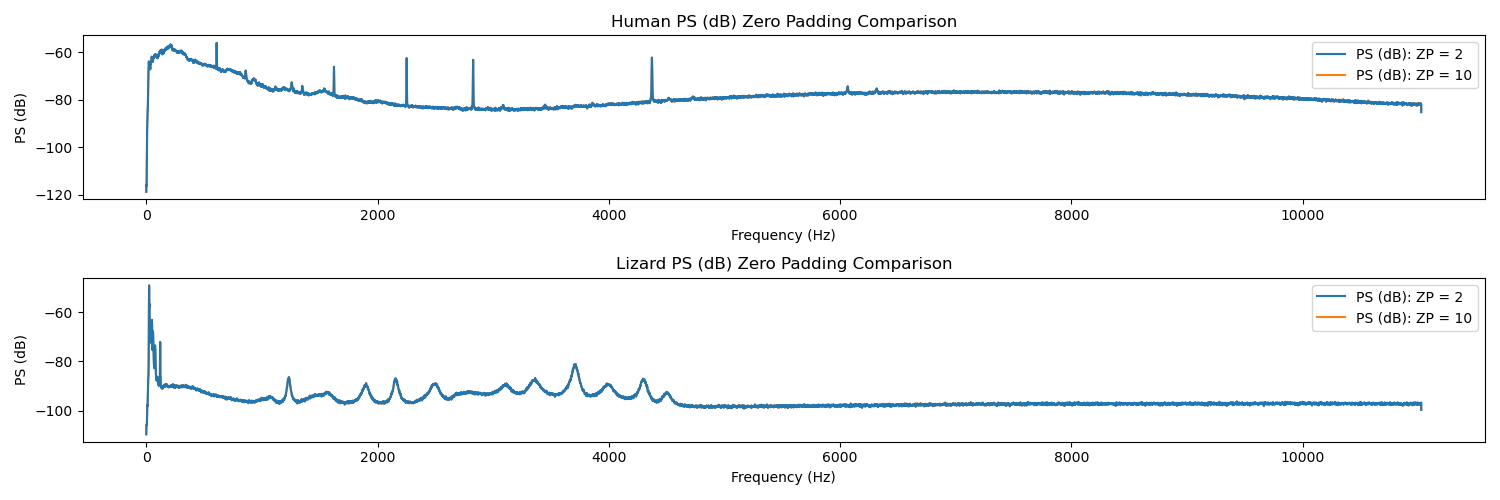

In [12]:
"PS/PSD Zero Padding Comparison"
wf_human_ds = wf_human[::2]
wf_lizard_ds = wf_lizard[::2]

# Set Welch params
fs = int(44100/2)
nperseg = 32768/2
detrend = None
scaling ='spectrum'
win_type = 'hann'

plt.figure(figsize=(15, 5))
# fs = 44100
# nperseg = 32768
# for i, (species, wf) in enumerate([("Human", wf_human), ("Lizard", wf_lizard)]):
for i, (species, wf) in enumerate([("Human", wf_human_ds), ("Lizard", wf_lizard_ds)]):
    plt.subplot(2, 1, (i+1))
    # Human
    for zpad in [2, 10]:
        plot_spectrum_zpad(wf, scaling, win_type, nperseg, zpad, species, fs=fs, zorder=int(100/zpad))

plt.tight_layout()
plt.show()

